In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos ={i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


Build the Dataset

In [ ]:
block_size = 3
X, Y = [],[]
for w in words:
    # print(w)
    context =[0] * block_size
    for ch in w+'.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '---->',itos[ix])
        context = context[1:]+[ix] #crop and append
X = torch.tensor(X) 
Y = torch.tensor(Y)
num = X.nelement() / block_size

<b>Indexing</b> and <b>one hot encoding</b> are two equilavent ways leads us to the same output. Since the indexing process is lower in terms of computation we are going to use it.

In [80]:
C = torch.randn((27,2)) # Look-up table
print(C[5])
xenc = F.one_hot(torch.tensor(5),num_classes=27).float()
logits = xenc @ C
print(logits) 

tensor([0.6942, 0.2126])
tensor([0.6942, 0.2126])


### EMBEDDING LAYER </br>
 **C** is the Table look-up. </br>
We embed the X tensor with C (we lowered the dimension) and with doing this we had a tensor which has <b> [element number,input,2] </b></br></br>
**element number**: it's the total number of how many steps we took to find all input output pairs in the training set. </br>
**input**: it's the total number of symbols to find a right output in this example is 3 </br>
**2**: lowered dimension (its by choice)</br></br>
We set **W1** with (6,100) because input * dimension which in this example 3*2 is equal to 6

In [81]:
C = torch.randn((27,2))
emb =C[X]
emb.shape

W1=torch.randn((6,100))
b1=torch.randn(100) 

### HIDDEN LAYER ACTIVISION'S </br>
**emb.view(-1,6)**: Means we have to concatenate the [x,3,2] vector to [x,6] to able to do the dot product operation. **-1** means dimension its equivalent to emb.shape[0] </br>


In [82]:
h= torch.tanh(emb.view(-1,6) @ W1 +b1)

### SOFTMAX 

In [83]:
W2=torch.randn((100,27))
b2 = torch.randn(27)
logits = h @ W2 +b2

counts = logits.exp()
prob = counts / counts.sum(1,keepdim=True)

### LOSS FUNCTION (NEGATIVE LOG LIKELIHOOD)

In [84]:
loss = -1*prob[torch.arange(int(num)),Y].log().mean()
loss

tensor(17.1713)

### CROSS ENTROPY </br>
All of the things we did above can be called as **CROSS ENTROPY**. Like: </br>
counts = logits.exp()  </br>
prob = counts / counts.sum(1,keepdim=True)  </br>
loss = -1*prob[torch.arange(int(num)),Y].log().mean()  </br>

In [85]:
F.cross_entropy(logits,Y)

tensor(17.1713)

### ALL TOGETHER 

#### TRAINING SPLIT (80%)</br>
Optimize the parameters. Using gradient descent. </br>
#### DEV/VALIDATION SPLIT(10%)</br>
Used for train **hyperparameters**.  **hyperparameters** such as hidden layers,size of embedding. </br>
#### TEST SPLIT(10%) </br>
Used to evaluate the performance of the model in the end. You should use it very very few times because the model is going to overfit that data.


In [156]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [157]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()

In [158]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [159]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [160]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [161]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [162]:
for p in parameters:
    p.requires_grad= True


In [163]:
#Set learning rate candidates.
lre = torch.linspace(-3,0,1000)
lrs = 10**lre
indexLR = 0

lri = []
lossi = []
stepi = []

In [182]:
while True:

    #MINIBATCH CONSTRUCT
    ix = torch.randint(0,Xtr.shape[0],(32,))

    #FORWARD PASS
    emb =C[Xtr[ix]] #Xtr[ix] = C[Xtr[ix] 
    # Without minibatch its [X,3,10] in this case [32,3,10]
    h = torch.tanh(emb.view(-1,30) @ W1 +b1) #[32,200]
    logits = h @ W2 +b2 #[32,27]
    loss = F.cross_entropy(logits,Ytr[ix])
    if loss.item() < 1.25:
        print(loss.item())
        break

    #BACKWARD PASS
    for p in parameters:
        p.grad = None
    loss.backward()

    #UPDATE
    step = 0.1 if indexLR <100000 else 0.01
    for p in parameters:
        p.data += -step * p.grad
    
    indexLR += 1
    #TRACK STATS
    #lri.append(lre[indexLr])
    stepi.append(indexLR)
    lossi.append(loss.log10().item())

1.2474005222320557


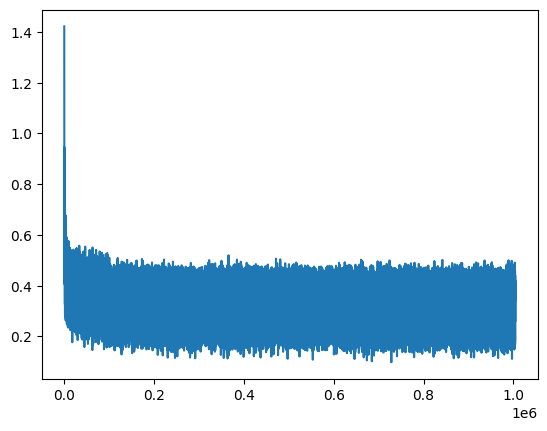

In [183]:
# Find the good learning rate
plt.plot(stepi,lossi)

In [184]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1034, grad_fn=<NllLossBackward0>)

In [185]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss


tensor(2.1528, grad_fn=<NllLossBackward0>)

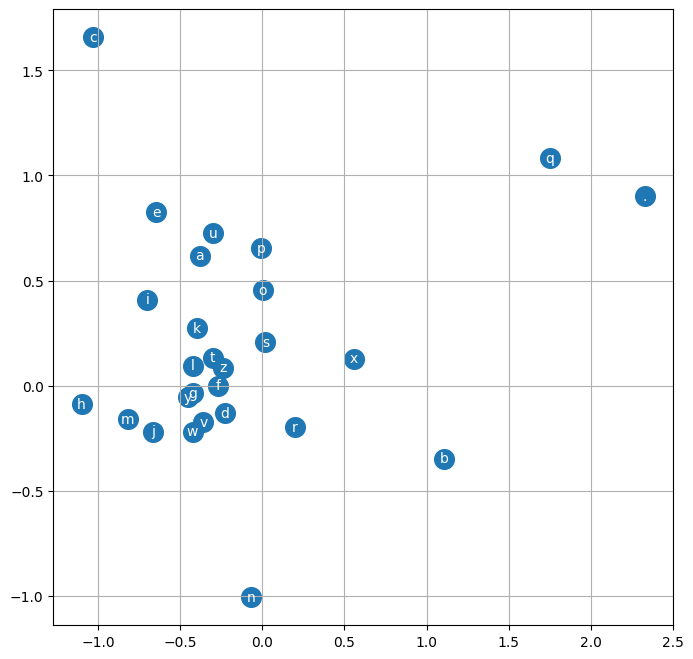

In [186]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [187]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [188]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mona.
mayanna.
elven.
ryla.
rethrutendraeg.
aderronelin.
shi.
jenne.
elisananas.
kayziah.
karin.
shabergiagrael.
kindreelynn.
novana.
ubakard.
ryyah.
fael.
yuma.
myston.
azhia.
